# Covered Calls Leap Trader

## Imports

In [45]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.io as pio
import yfinance as yf

from dateutil.relativedelta import relativedelta

from tqdm import tqdm
tqdm.pandas()

In [65]:
# Get options data `AFTER_DATE`
AFTER_DATE = pd.to_datetime('2018-01-01')
BEFORE_DATE = pd.to_datetime('2023-12-31')

# Sets a maximum days to expiration
MAX_DAYS_TILL_EXPIRATION = 400

# Sets the ticker to trade
TICKERS = ['QQQ', 'SPY']

market_dates = yf.download('SPY').index
pd.set_option('display.float_format', '{:.6f}'.format)  

[*********************100%***********************]  1 of 1 completed


## Read In File

In [47]:
# Initialize a dictionary to hold dataframes for each ticker
portfolio_option_data = {}

# Iterate through tickers and set dictionary to hold proper data
for TICKER in TICKERS:
    
    print(TICKER)
    
    # Read data
    portfolio_option_data[TICKER] = pd.read_parquet(f'../read_data/data/clean/{TICKER}.parquet')

QQQ
SPY


In [48]:
stocks = yf.download(['TQQQ', 'SPXL'])
stocks.index = stocks.index.tz_localize(None)
stocks = stocks.rename(columns={'TQQQ': 'QQQ', 'SPXL': 'SPY'}, level=1)
stocks.columns

[*********************100%***********************]  2 of 2 completed


MultiIndex([('Adj Close', 'SPY'),
            ('Adj Close', 'QQQ'),
            (    'Close', 'SPY'),
            (    'Close', 'QQQ'),
            (     'High', 'SPY'),
            (     'High', 'QQQ'),
            (      'Low', 'SPY'),
            (      'Low', 'QQQ'),
            (     'Open', 'SPY'),
            (     'Open', 'QQQ'),
            (   'Volume', 'SPY'),
            (   'Volume', 'QQQ')],
           names=['Price', 'Ticker'])

In [49]:
portfolio_leap_options = {}

# Find best leap contracts
for TICKER in TICKERS:
    print(TICKER)

    # Group by date
    portfolio_leap_options[TICKER] = portfolio_option_data[TICKER].groupby(['date']).progress_apply(

        # Iterate through each group (for other code readers, think about the following code as a function for each `date` within the all_options_data dataframe)
        lambda group: group.loc[

            # Get first `expiration_date` that surpasses year from `date`... aka first leap
            (group['expiration_date'] == group.loc[
                group['expiration_date'] > (group.name + relativedelta(months=11))]
                ['expiration_date'].min())
            
            ]

            # Of these `expiration_date`s, make sure that `days_till_expiration` < criteria
            .loc[group['days_till_expiration'] < MAX_DAYS_TILL_EXPIRATION]

            # Of these `expiration_date`s with aforementioned critetia, obtain the option with the smallest `strike_distance`
            .nsmallest(1, 'strike_distance')

            # Output these column
            [['expiration_date', 'strike', 'days_till_expiration', 'put_price', 'stock_price']]

        # Reset index so date is column and drop added `level_1` index
        ).reset_index().drop(columns = ['level_1']).dropna()

QQQ


100%|██████████| 3017/3017 [00:03<00:00, 790.59it/s]


SPY


100%|██████████| 3500/3500 [00:05<00:00, 660.20it/s]


In [50]:
all_strategies = {}
# Iterate through strategies
for TICKER in TICKERS:
    print(TICKER)
    
    # Get leaps after date and before date
    strat = portfolio_leap_options[TICKER].copy()
    strat['sell_date'] = strat.progress_apply(lambda row: np.max([date for date in market_dates if date < row['expiration_date']]), axis=1)
    strat['last_price'] = strat.progress_apply(lambda row: portfolio_option_data[TICKER].loc[
        (portfolio_option_data[TICKER]['expiration_date'] == row['expiration_date']) &
        (portfolio_option_data[TICKER]['strike'] == row['strike']) & 
        (portfolio_option_data[TICKER]['date'] <= row['sell_date'])
    ]['put_price'].iloc[-1], axis=1)
    all_strategies[TICKER] = strat

stocks = stocks[AFTER_DATE:BEFORE_DATE]
all_strategies.keys()

QQQ


100%|██████████| 1842/1842 [00:36<00:00, 50.52it/s]


SPY


100%|██████████| 2944/2944 [01:29<00:00, 33.03it/s]


dict_keys(['QQQ', 'SPY'])

## Get Leap Options After Date

In [66]:
strategies = {}
# Iterate through strategies
for TICKER in TICKERS:
    print(TICKER)
    
    # Get leaps after date and before date
    strat = all_strategies[TICKER].loc[(all_strategies[TICKER]['date'] > AFTER_DATE) & (all_strategies[TICKER]['expiration_date'] < BEFORE_DATE)].copy()
    strategies[TICKER] = strat

strategies.keys()

QQQ
SPY


dict_keys(['QQQ', 'SPY'])

In [67]:
strategies[TICKER]

,date,expiration_date,strike,days_till_expiration,put_price,stock_price,sell_date,last_price
1631,2018-01-02,2018-12-21,269.000000,353,13.625000,268.810000,2018-12-20,3.355000
1632,2018-01-03,2018-12-21,270.000000,352,13.130000,270.470000,2018-12-20,3.730000
1633,2018-01-04,2018-12-21,271.000000,351,13.065000,271.560000,2018-12-20,12.035000
1634,2018-01-05,2018-12-21,273.000000,350,13.160000,273.410000,2018-12-20,13.910000
1635,2018-01-08,2018-12-21,274.000000,347,13.300000,273.940000,2018-12-20,14.900000
...,...,...,...,...,...,...,...,...
2751,2023-01-23,2023-12-29,400.000000,340,25.685000,400.630000,2023-12-28,0.005000
2752,2023-01-24,2023-12-29,400.000000,339,25.140000,400.230000,2023-12-28,0.005000
2753,2023-01-25,2023-12-29,400.000000,338,24.935000,400.320000,2023-12-28,0.005000
2754,2023-01-26,2023-12-29,405.000000,337,24.650000,404.730000,2023-12-28,0.005000


## Determine Which Options To Trade

In [68]:
def leaps_to_trade(leap_options):
    # Set first leap to the first `leap_options['date']`
    leap_dates = [leap_options['date'].iloc[0]]

    # Set the first `sell_date` to the sell date of the first `leap_options['date']`
    sell_date = leap_options.loc[leap_options['date'] == leap_dates[-1]]['sell_date'].iloc[0]

    # Iterate through the `leap_options` until the `sell_date` > the last `leap_options['date']`
    while sell_date < leap_options['date'].iloc[-1]:

        leap_dates.append(leap_options.loc[leap_options['date'] > sell_date]['date'].iloc[0])

        # Set `sell_date` to the expiration date of the previously appended `leap_dates`
        sell_date = leap_options.loc[leap_options['date'] == leap_dates[-1]]['sell_date'].iloc[0]

    return leap_dates

# Initiate a dictionary to find each trade performed
portfolio_trades = {}

# Iterate through each ticker
for TICKER in TICKERS:
    leap_dates = leaps_to_trade(strategies[TICKER])

    # Get all the options from `leap_options` with the starting dates within `leap_dates`
    portfolio_trades[TICKER] = strategies[TICKER].loc[strategies[TICKER]['date'].isin(leap_dates)].reset_index(drop=True).dropna()

In [69]:
portfolio_trades['SPY']

,date,expiration_date,strike,days_till_expiration,put_price,stock_price,sell_date,last_price
0,2018-01-02,2018-12-21,269.000000,353,13.625000,268.810000,2018-12-20,3.355000
1,2018-12-21,2019-12-20,241.000000,364,18.590000,240.720000,2019-12-19,0.005000
2,2019-12-20,2020-12-18,321.000000,364,19.270000,320.850000,2020-12-17,0.010000
3,2020-12-18,2021-12-17,369.000000,364,31.815000,369.230000,2021-12-16,0.005000
4,2021-12-17,2022-12-16,460.000000,364,39.835000,459.860000,2022-12-15,72.315000
5,2022-12-19,2023-12-15,380.000000,361,30.750000,380.020000,2023-12-14,0.005000


In [73]:
portfolio_trades['QQQ']

,date,expiration_date,strike,days_till_expiration,put_price,stock_price,sell_date,last_price
0,2018-01-02,2018-12-31,158.000000,363,9.970000,158.450000,2018-12-28,5.335000
1,2018-12-31,2020-01-17,154.000000,382,14.155000,154.120000,2020-01-16,0.010000
2,2020-01-17,2020-12-18,223.000000,336,13.725000,223.380000,2020-12-17,0.005000
3,2020-12-18,2021-12-17,310.000000,364,32.070000,310.010000,2021-12-16,0.010000
4,2021-12-17,2022-12-16,385.000000,364,38.655000,384.960000,2022-12-15,108.080000
5,2022-12-19,2023-12-15,270.000000,361,25.900000,269.890000,2023-12-14,0.005000


## Trade Options

In [70]:
initial_investment = 1000000
stock_data = {}
stock_shares = {}
for TICKER in TICKERS:
    ret = stocks['Adj Close'][TICKER].pct_change()
    stock_data[TICKER] = ret
    stock_data[TICKER] = stock_data[TICKER][AFTER_DATE:BEFORE_DATE]
    stock_shares[TICKER] = initial_investment / stocks['Adj Close'][TICKER].iloc[0]


In [ ]:

def invest_earnings(option_data, current_shares, current_share_price, total_investment, option_gain_prior):
    """
    option_data: slice of DF containing all rows/dates for the option we hold
    current_shares: (float) how many shares we currently own
    current_share_price: share price at the time we buy the put
    total_investment: total $ amount in stock at that time (current_shares * current_share_price)
    """
    # 10% of the total_investment is allocated to puts
    # each option contract covers 100 shares
    cost_per_contract = option_data.iloc[0]['put_price'] * 100
    num_puts = np.round(((total_investment) * 0.05) / cost_per_contract)

    # Deduct the cost of the puts from the stock portion
    # i.e., we reduce the number of shares to free up that capital
    cost_of_puts = num_puts * cost_per_contract
    print(cost_of_puts)
    shares_sold = cost_of_puts / current_share_price
    updated_shares = current_shares - shares_sold
    
    # Compute the profit time series from these puts
    # Profit per day = (# of contracts * 100) * [put_price(t) - put_price(0)]
    put_profit = num_puts * 100 * (option_data['put_price']) + option_gain_prior
    
    # Build a DataFrame with date/profit info
    put_profit_df = pd.DataFrame({
        'date': option_data['date'],
        'profit': put_profit,
        'start_date': option_data.iloc[0]['date'],
        'end_date': option_data.iloc[-1]['date']
    }).sort_values(by='date')
    
    # Build a DataFrame tracking how many shares are left
    # We'll create it only for the day we made this transaction
    share_data_df = pd.DataFrame(
        {'shares': [updated_shares]},
        index=[option_data.iloc[0]['date']]
    )

    last_put_profit = put_profit_df.iloc[-1]['profit']

    return put_profit_df, share_data_df, last_put_profit

# -------------------------------------------------------------------
# 3) Main loop: for each TICKER, gather results
# -------------------------------------------------------------------
results = {}
all_shares = {}

for TICKER in TICKERS:
    print("Processing:", TICKER)

    # Start with the number of shares we had from the initial 1M at T=0
    num_shares = stock_shares[TICKER]

    # These lists will accumulate DataFrames
    ticker_results_list = []
    share_tick_list = []
    option_gain_prior = 0

    # Go through each row in our "portfolio_trades" for that ticker
    for _, put_leap in portfolio_trades[TICKER].iterrows():
        print(put_leap['date'])
        
        # Slice the option data to only the matching expiration date, strike, and time window
        put_follow = portfolio_option_data[TICKER].loc[
            (portfolio_option_data[TICKER]['expiration_date'] == put_leap['expiration_date']) & 
            (portfolio_option_data[TICKER]['strike'] == put_leap['strike']) & 
            (portfolio_option_data[TICKER]['date'] >= put_leap['date']) &
            (portfolio_option_data[TICKER]['date'] <= put_leap['sell_date'])
        ]
        
        # Calculate how much $ we currently have in the stock
        share_price = stocks['Adj Close'][TICKER].loc[put_leap['date']]
        investment_value = num_shares * share_price
        
        # Call the function to invest in the put and adjust shares
        tick_results, share_data, gain_prior = invest_earnings(
            put_follow, 
            current_shares=num_shares, 
            current_share_price=share_price, 
            total_investment=investment_value,
            option_gain_prior=option_gain_prior
        )

        option_gain_prior = gain_prior
        
        # Collect the DataFrames
        ticker_results_list.append(tick_results)
        share_tick_list.append(share_data)

        # Update our number of shares to what the function returned
        num_shares = share_data['shares'].iloc[0]
        print('-----------------------------------')

    # Sort the individual put-profit DataFrames by their start_date
    ticker_results_list = sorted(ticker_results_list, key=lambda df: df.iloc[0]['start_date'])
    # Then concatenate them
    ticker_results_df = pd.concat(ticker_results_list, ignore_index=True).sort_values(by='date')
    
    # Make 'date' the index
    ticker_results_df = ticker_results_df.set_index('date', drop=True)

    # Now the shares:
    share_tick_list = sorted(share_tick_list, key=lambda df: df.index[0])
    share_tick_df = pd.concat(share_tick_list)
    
    # We want a consistent date index that includes *both* option P/L and stock returns
    full_index = ticker_results_df.index.union(stock_data[TICKER].index)

    # Reindex everything on that union, forward-fill
    ticker_performance = ticker_results_df.reindex(full_index).ffill()
    stock_performance = stock_data[TICKER].reindex(full_index).ffill()
    share_tick_df = share_tick_df.reindex(full_index).ffill()

    # The stock portion grows by (1 + daily_return).cumprod() if we never changed shares
    # But since we do occasionally change shares, let's keep it simple:
    #   Start with 'share_tick_df["shares"]' as of the first day
    #   Then apply (1 + stock_performance).cumprod() to track the *price* changes
    #   multiplied by the *current* number of shares, scaled by the initial price or daily price
    #
    # If your intent is to recalc daily, you might do something else more dynamic. 
    # For a simpler approach:
    stock_initial_price = stocks['Adj Close'][TICKER].iloc[0]
    stock_price_growth = (1 + stock_performance).cumprod()
    
    # Value of the stock holding over time:
    stock_share_value = stock_price_growth * share_tick_df['shares'] * stock_initial_price
    
    # Combine (put profits + stock share value). 
    # We divide by the original 'investment_value' if you want a return multiple
    combo_results = ticker_performance['profit'] + stock_share_value
    
    # pd.set_option('display.max_rows', None)
    # print(ticker_performance)
    # pd.reset_option('display.max_rows')
    break

    
    # Be careful with "investment_value": after multiple trades, 
    # you may want to scale by the original 'initial_investment' or do it run‐by‐run. 
    # Below we just scale by the *final* iteration's investment_value or the initial_investment:
    results[TICKER] = combo_results / initial_investment



Processing: QQQ
2018-01-02 00:00:00
812554.9999999999
-----------------------------------
2018-12-31 00:00:00
610080.5
-----------------------------------
2020-01-17 00:00:00
1527592.5000000002
-----------------------------------
2020-12-18 00:00:00
2517495.0
-----------------------------------
2021-12-17 00:00:00
4120623.0
-----------------------------------
2022-12-19 00:00:00
1541050.0
-----------------------------------


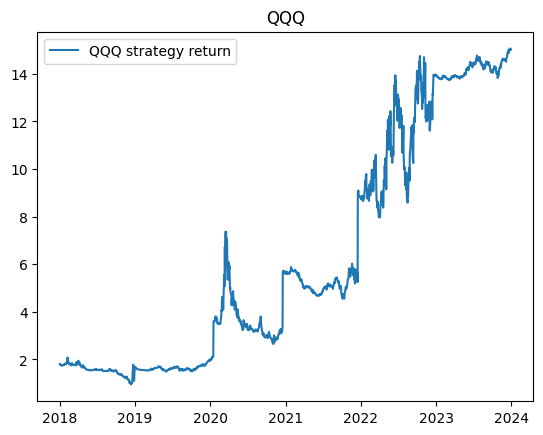

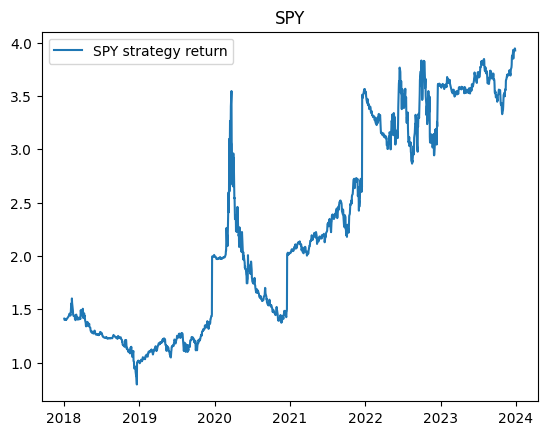

In [87]:
# -------------------------------------------------------------------
# 4) Plot the results
# -------------------------------------------------------------------
for TICKER in TICKERS:
    if TICKER not in results:
        continue
    plt.title(TICKER)
    plt.plot(results[TICKER], label=f"{TICKER} strategy return")
    plt.legend()
    plt.show()
